In [1]:
import os, sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

from DL_attacks import DL, user, utils, ops_on_vars_list
from exp_setups import *
from exp_setups.STL10 import * 
import DL_attacks.attacker_active
from DL_attacks.model import binary_accuracy

rng_seed = 0
np.random.seed(rng_seed)
tf.random.set_seed(rng_seed)

# Setup State-override attack

In [2]:
from GradientInversion import adv_params_init

# hardwired params for the attack
nu = 5
VICTIM = 1
VICTIM_NN = [2]
fully_id = -4
bias_id = -3
fully_init_hp = [0., .5, .5]
batch_size = 64
size_local_ds = 500
size_testset = 500
learning_rate = 1.

# simple relu-based cnn
def cnn(input_shape, output_shape, _, init_lr, epsilon=0.00001):
    padding = 'same'
    
    xin = tf.keras.layers.Input(input_shape)
    
    # normalize input in [0, 1]
    x = (xin + 1.) / 2.
    x = tf.keras.layers.Conv2D(16, 3, 1, activation='relu', padding=padding)(x)
    x = tf.keras.layers.Conv2D(32, 3, 1, activation='relu', padding=padding)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(144, activation='relu')(x)
    x = tf.keras.layers.Dense(output_shape)(x)
    y = tf.keras.layers.Softmax()(x)

    model = tf.keras.Model(inputs=xin, outputs=y)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    opt = lambda : tf.keras.optimizers.SGD(init_lr)
    
    return model, loss, opt, binary_accuracy


# attacker class with hard-coded payload
class Attacker_override_with_trap_relu(attacker_active.StateOverideAttacker):
    
    def get_targets(self):
        return VICTIM, VICTIM_NN
        
    def make_payload(self):
        _model = ops_on_vars_list.deepCopyModel(self.model)
        
        for layer in [0, 2]:
            kernel = _model.trainable_variables[layer]
            kernel.assign(np.zeros(kernel.shape))

            adv_params_init.modify_filter(_model, layer, 0, 0)
            adv_params_init.modify_filter(_model, layer, 1, 1)
            adv_params_init.modify_filter(_model, layer, 2, 2)

        ## init fully connected
        kernel = _model.trainable_variables[fully_id]
        adv_params_init.w_fully_adv_init(kernel,  *fully_init_hp)
        
        return _model.trainable_variables

# Setup Topology and DL framework

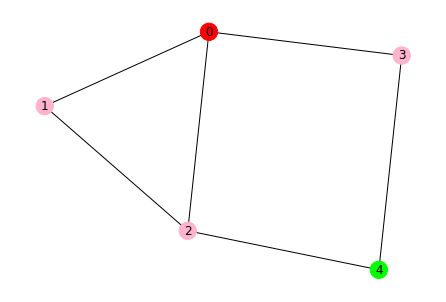

In [3]:
CDL = DL.Ring
ATTACKER = Attacker_override_with_trap_relu

train_sets, test_set, x_shape, num_class = utils.setup_data(
    load_dataset,
    nu,
    size_local_ds,
    batch_size,
    size_testset,
    type_partition
)

make_model = utils.setup_model(cnn, [x_shape, num_class, [], learning_rate], model_same_init)
dl = CDL(graph_properties)
dl.setup(nu, make_model, train_sets, test_set, USER, ATTACKER)

# connecting attacker to vitcim's neighbors
att = dl.attacker
victim = dl.U[att.victim]
rely_nn = dl.U[att.victim+1]
rely_nn.neighbors.add(att)
att.neighbors.add(rely_nn)    

dl.model_graph();

# Run protocol (two rounds are enough)

In [4]:
dl()
dl()

# Recover attack result

In [5]:
att =  dl.attacker
# get victim's model update
v_model_update = att.model_update_buffer[att.victim]
payload = att.payload

# recover gradient 
n = len(v_model_update)
gradient = [None] * n
for i in range(n):
    gradient[i] = -(v_model_update[i] - payload[i]) / learning_rate
    
# Recover images 
n = gradient[fully_id].shape[1]
Xr = []
for i in range(n):
    x = adv_params_init.invert_fully_g(gradient[fully_id], gradient[bias_id], i)
    x = x.reshape(x_shape[0], x_shape[1], 32)
    x = x[:,:,:3]
    x = adv_params_init.normalize_img(x)
    Xr.append(x)

# Plot recovered imgs (raw)

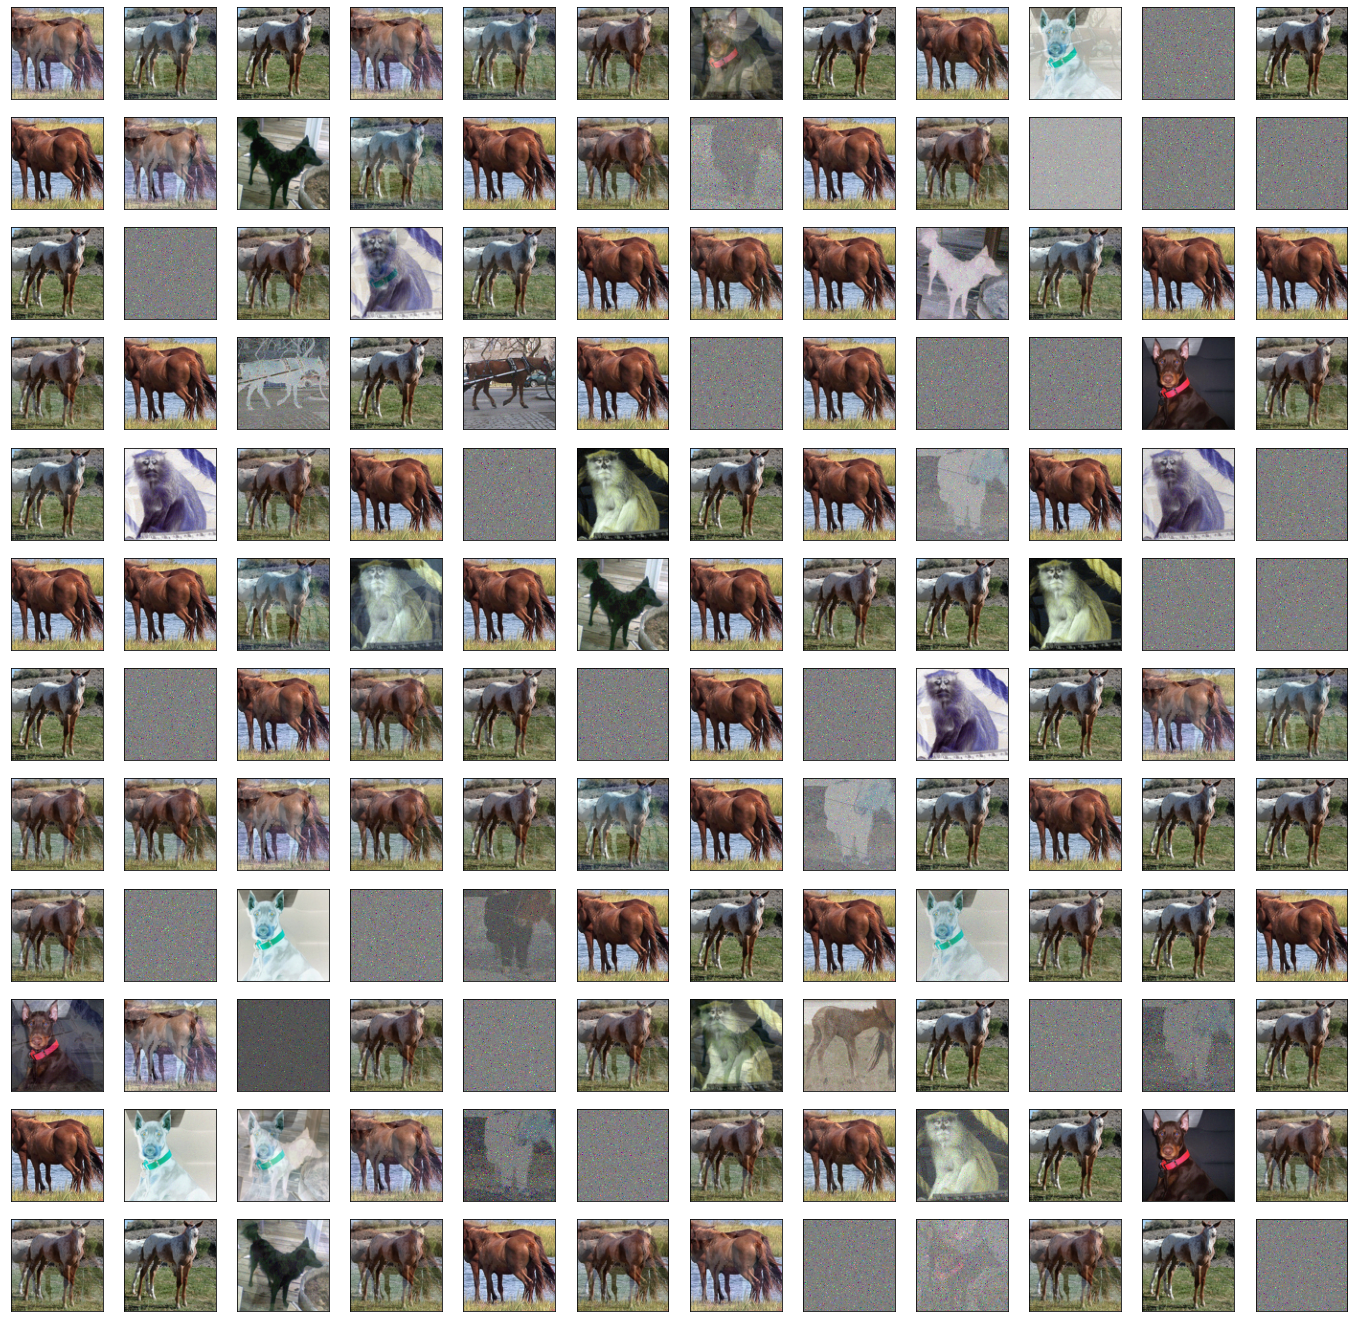

In [6]:
n = len(Xr)
m = math.floor(math.sqrt(n))

k = 2
fig, ax = plt.subplots(m, m, figsize=(m*k, m*k));

for i in range(m):
    for j in range(m):    
        ax[i, j].imshow(Xr[i*m+j])
        ax[i, j].set(xticks=[], yticks=[])